## Utils

In [ ]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1-koULT_rZz1E6VJJVYa-hnLXdy6XSZe2'
destination = '/content/data.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip -q data.zip
!rm -rf data.zip

# Regression with RANSAC for Robust curve fitting (2 mark)

For a given polynomial, \\
$$y_{i}=\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\cdots+\beta_{m} x_{i}^{m}+\varepsilon_{i}(i=1,2, \ldots, n)$$

we can express it in a form of matrix $\mathbf{X}$, a response vector or $\vec{y}$, a parameter vector $\vec{\beta}$, and a vector $\vec{\varepsilon}$ of random errors. The model can be represented as system of linear equations, i.e.



$$\left[\begin{array}{c}y_{1} \\ y_{2} \\ y_{3} \\ \vdots \\ y_{n}\end{array}\right]=\left[\begin{array}{ccccc}1 & x_{1} & x_{1}^{2} & \ldots & x_{1}^{m} \\ 1 & x_{2} & x_{2}^{2} & \ldots & x_{2}^{m} \\ 1 & x_{3} & x_{3}^{2} & \ldots & x_{3}^{m} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n} & x_{n}^{2} & \ldots & x_{n}^{m}\end{array}\right]\left[\begin{array}{c}\beta_{0} \\ \beta_{1} \\ \beta_{2} \\ \vdots \\ \beta_{m}\end{array}\right]+\left[\begin{array}{c}\varepsilon_{1} \\ \varepsilon_{2} \\ \varepsilon_{3} \\ \vdots \\ \varepsilon_{n}\end{array}\right]$$

$$or$$

$$\vec{y}=\mathbf{X} \vec{\beta}+\vec{\varepsilon}$$

For this system, we can calculate $\vec{\beta}$ by using the following formula,
$$
\widehat{\vec{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \vec{y}
$$

Using **RANSAC**, we want to avoid outliers in our curve fitting, and thus we will calculate multiple $\vec{\beta_i}$s using a set of datapoints. After calculating several $\vec{\beta_i}$ we will find the best value of ${\beta}$ using _least squares_.

In [ ]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt



class Regression:
    def __init__(self,order,bias=True):
        """
        Initialize regressor
        :param order: order of the polynomial
        :param bias: boolean, True for our case
        """

        self.order = order
        self.bias = bias

        self.beta = np.zeros(order + bias)

    
    def calculation(self,x,y):
        x_t = np.transpose(x)
        multiply = np.dot(x_t,x)
        inverse = np.linalg.inv(multiply)
        temp = np.dot(inverse,x_t)
        b_ta = np.dot(temp,y)
        return b_ta

    def solve(self,x,y,n,iterations=10000):
        '''
        # For 1.5 marks
        Function to solve regression using RANSAC
        :param x: input
        :param y: output
        :param n: number of dataset per iteration
        :param iterations: number of iterations to find best beta 
        '''
        ## TODO
        threshold = 0.04*(order**2)
        besterr = np.inf
        bestfit = None
        inliers_indices=[]
        for i in range(iterations):
          rand = random.sample(range(0,len(x)),n)
          x_rand = np.zeros([n,(order+1)])
          y_rand = np.zeros([n,1])
          for j in range(0,n):
            for k in range(0,order+1):
              x_rand[j][k] = x[rand[j]]**k
            y_rand[j][0] = y[rand[j]]
          temp_beta = self.calculation(x_rand,y_rand)
        
          temp_inliers=[]
          for j in range(0,len(x)):
            y_function=0
            if j not in rand:
              for k in range(0,order+1):
                y_function += temp_beta[k][0]*(x[j]**k)
              if abs(y_function-y[j])<threshold:
                temp_inliers.append(j)
      
          if len(temp_inliers)>len(x)*0.2:   
            data_indices = []
            for j in range(0,len(rand)):
              data_indices.append(rand[j])
            for j in range(0,len(temp_inliers)):
              data_indices.append(temp_inliers[j])
          
            x_matrix_updated = np.zeros([len(data_indices),(order+1)])
            y_matrix_updated = np.zeros([len(data_indices),1])
            for j in range(0,len(data_indices)):
              for k in range(0,order+1):
                x_matrix_updated[j][k] = x[data_indices[j]]**k
              y_matrix_updated[j][0] = y[data_indices[j]]
            temp_beta_updated = self.calculation(x_matrix_updated,y_matrix_updated)
        
            error=0
            for j in range(0,len(x)):
              sum = 0
              for k in range(0,order+1):
                sum += temp_beta_updated[k][0]*(x[j]**k)
              difference = y[j]-sum
              error += difference**2
            error = error/len(x)
            if error < besterr:
              bestfit = temp_beta_updated
              besterr = error
        
        inliers_x=[]
        inliers_y=[]
        for j in range(0,len(x)):
            y_value=0
            for k in range(0,order+1):
              y_value += bestfit[k][0]*(x[j]**k)
            if abs(y_value-y[j])<threshold:
              inliers_indices.append(j)
              inliers_x.append(x[j])
              inliers_y.append(y[j])
        print(bestfit)
        print(besterr)
  
        return besterr, bestfit, inliers_x,inliers_y,inliers_indices
    
    def visualize(self,x,y,bestfit,inliers_x,inliers_y,inliers_indices,show=False):
        '''
        # For 0.5 marks
        function to visualize datapoints and optimal solution.
        '''
        # TODO
        p=np.linspace(-1, 1, 100)
        y_p=[]

        for j in range(0,len(p)):
          sum = 0
          for k in range(0,bestfit.shape[0]):
            sum += bestfit[k][0]*(p[j]**k)
          y_p.append(sum)

        outliers_x  =[]
        outliers_y = []
        for j in range(0,len(x)):
          if j not in inliers_indices:
            outliers_x.append(x[j])
            outliers_y.append(y[j])
        
        fig = plt.figure(figsize =(10, 10))
        plt.plot(p,y_p, label="bestfit",color="blue")
        plt.scatter(inliers_x,inliers_y, label="inliers",color="green")
        plt.scatter(outliers_x,outliers_y,label="outliers",color="red")
        plt.legend()
        plt.show()


## Solve and Visualize for 2nd Order (1.5 mark)

Load the dataset, solve the regression, and finally report the coeffecients, with best least square error. Also visualize it on graph.

[[1.11882074]
 [2.14463176]
 [2.84138812]]
1.0219286362829965


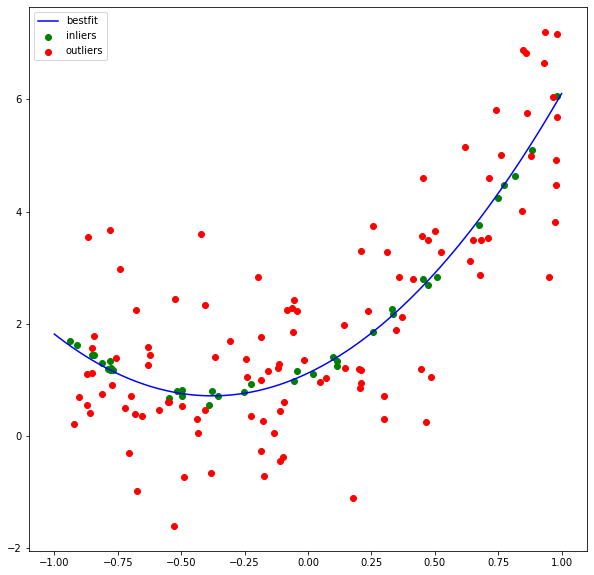

In [ ]:
import pandas as pd

file=pd.read_csv('2nd_order.csv')
X=file['x']
Y=file['y']
n=40
order=2
object1 = Regression(order=2,bias=True)
besterr,bestfit,inliers_x,inliers_y,inliers_indices= object1.solve(X,Y,n,10000)

object1.visualize(X,Y,bestfit,inliers_x,inliers_y,inliers_indices,True)



## Solve and Visualize for 3rd Order (1.5 mark)

[[0.7836459 ]
 [2.00519959]
 [3.56021073]
 [3.78935967]]
3.336466023819207


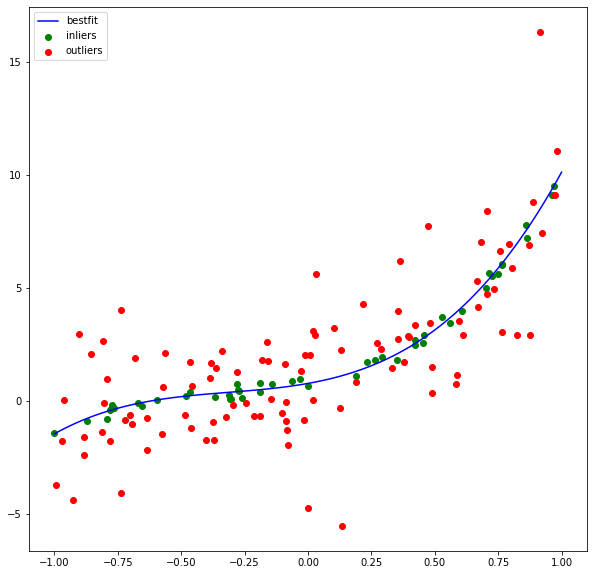

In [ ]:
import pandas as pd

file=pd.read_csv('3rd_order.csv')

X=file['x']
Y=file['y']
n=40
order=3
object1 = Regression(order=3,bias=True)
besterr,bestfit,inliers_x,inliers_y,inliers_indices= object1.solve(X,Y,n,10000)

object1.visualize(X,Y,bestfit,inliers_x,inliers_y,inliers_indices,True)

## Solve and Visualize for 4th Order (1.5 mark)

[[1.1003764 ]
 [2.67732479]
 [3.81658832]
 [2.72643527]
 [3.65556093]]
7.225009062277632


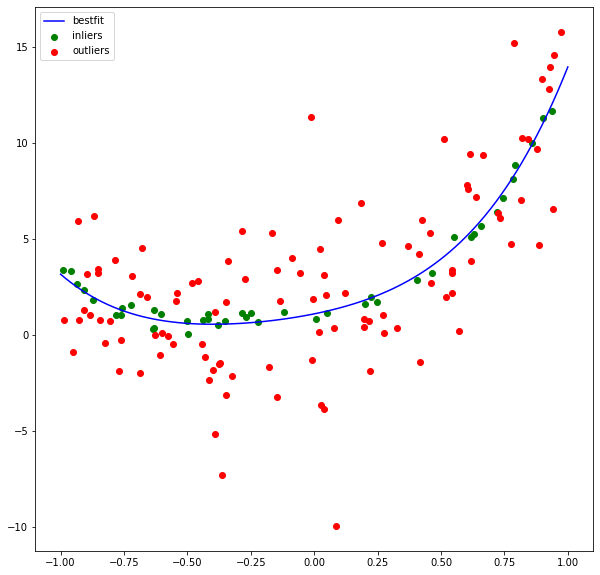

In [ ]:
import pandas as pd

file=pd.read_csv('4th_order.csv')

X=file['x']
Y=file['y']
n=40
order=4
object1 = Regression(order=4,bias=True)
besterr,bestfit,inliers_x,inliers_y,inliers_indices= object1.solve(X,Y,n,10000)

object1.visualize(X,Y,bestfit,inliers_x,inliers_y,inliers_indices,True)

## Report

### What is Linear Regression? (1 mark)

Linear Regression is a type of predictive analysis. It is used to predict the value of a one variable based on the value of the another variable. The variable you want to predict is called the dependent variable. The variable you are using to predict the other variable's value is called the independent variable.

### Why RANSAC? (1 mark)

We use RANSAC because it is a iterative method which estimate the parameters of mathematical model without the influence of outliers. An advantage of RANSAC is its ability to do robust estimation of the model parameters, i.e., it can estimate the parameters with a high degree of accuracy even when a significant number of outliers are present in the data set.

### How does RANSAC help curve fitting? (1.5 marks) 
[not more than 4-5 sentences]

The RANSAC algorithm creates a fit from a small sample of points but tries to maximize the number of inlier points. 

The RANSAC algorithm is essentially composed of two steps that are iteratively repeated:

1.In the first step, a sample subset containing minimal data items is randomly selected from the input dataset. A fitting model and the corresponding model parameters are computed using only the elements of this sample subset. 

2.In the second step, the algorithm checks which elements of the entire dataset are consistent with the model instantiated by the estimated model parameters obtained from the first step. 